# Predict readmission within 30 days of discharge

In this notebook we battled the binary classification problem of trying to predict a readmission or not of patients within 30 days of discharge.


In [0]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# upload data to google drive and enter the file path

base_folder = '/gdrive/My Drive/Colab Notebooks/ML4HC/project2/data/10k_diabetes/'

def read_file(base_folder, filename):
    df = pd.read_csv(base_folder + filename)
    labels = df['readmitted'].values
    df.drop('readmitted', axis=1, inplace=True)
    df.replace('?',np.nan,inplace=True)
    return df, labels

In [0]:
# read datasets

df_train, y_train = read_file(base_folder, 'diab_train.csv')
df_val, y_val = read_file(base_folder, 'diab_validation.csv')
df_test, y_test = read_file(base_folder, 'diab_test.csv')

In [0]:
print(df_train.shape)
print(df_train.dtypes.value_counts())

(6000, 51)
object    42
int64      9
dtype: int64


## Data Visualization

In [0]:
import seaborn as sns
from matplotlib import gridspec

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


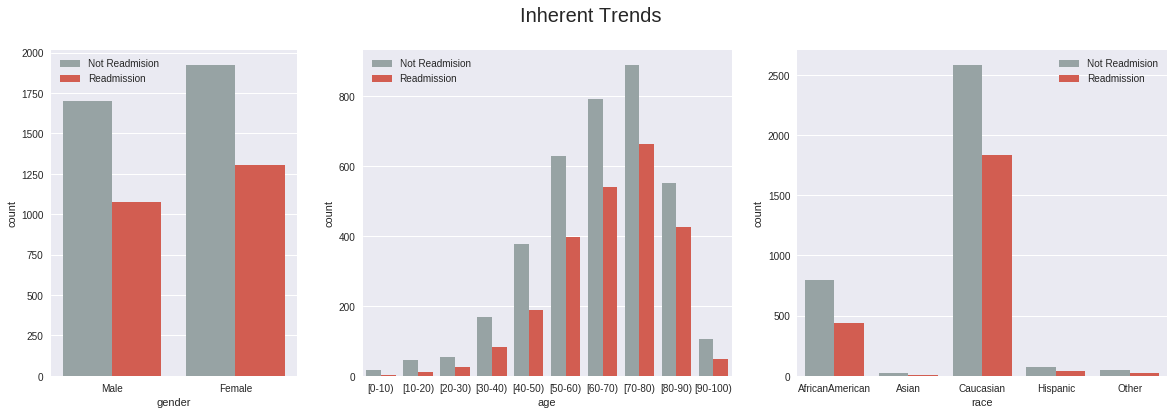

In [0]:
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1.5,1.5])
sns.set_palette(["#95a5a6", "#e74c3c"])
fig = plt.figure(figsize=(20, 6))
plt.subplot(gs[0])
sns.countplot(x='gender',data=df_train,hue=y_train,orient='v')
plt.legend(['Not Readmision','Readmission'])
plt.subplot(gs[1])
sns.countplot(x='age',data=df_train,hue=y_train,orient='v',order=sorted(df_train['age'].unique()))
plt.legend(['Not Readmision','Readmission'])
plt.subplot(gs[2])
sns.countplot(x='race',data=df_train,hue=y_train,orient='v',order=['AfricanAmerican','Asian', 'Caucasian','Hispanic','Other'])
fig.suptitle("Inherent Trends",fontsize=20)
plt.legend(['Not Readmision','Readmission'])

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


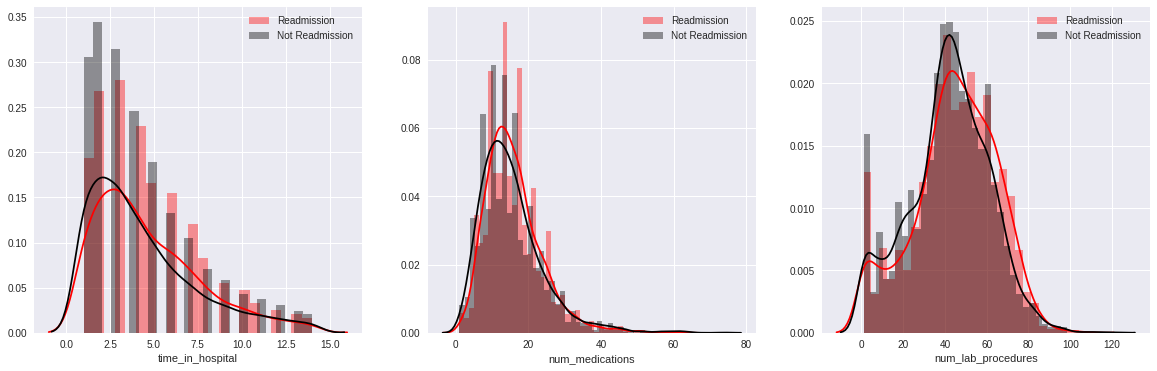

In [0]:
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1,1])
fig = plt.figure(figsize=(20, 6))
plt.subplot(gs[0])
sns.distplot(df_train.loc[y_train==1]['time_in_hospital'],color='r',label='Readmission')
sns.distplot(df_train.loc[y_train==0]['time_in_hospital'],color='0',label='Not Readmission')
plt.legend()
plt.subplot(gs[1])
sns.distplot(df_train.loc[y_train==1]['num_medications'],color='r',label='Readmission')
sns.distplot(df_train.loc[y_train==0]['num_medications'],color='0',label='Not Readmission')
plt.legend()
plt.subplot(gs[2])
sns.distplot(df_train.loc[y_train==1]['num_lab_procedures'],color='r',label='Readmission')
sns.distplot(df_train.loc[y_train==0]['num_lab_procedures'],color='0',label='Not Readmission')
plt.legend()


The most challenging task for this project was to properly preprocess the available dataset. 
For this goal, at first , irrelevant or those with many missing values features disrecarded from the training process.
Then, the remaing ones are cleaned (i.e filling missing values) and categorical features are encoded appropriately. Finally, various algorithms are implemented in order to reach the best result in terms of the desirable metrics.

## Data statistics

In [0]:
# Print the columns with the most amount of unkown values

df_train.isnull().apply(sum, axis=0).sort_values(ascending=False).head(10)

weight                      5757
payer_code                  3211
medical_specialty           2440
admission_source_id          551
admission_type_id            416
discharge_disposition_id     283
race                         124
diag_3_desc                  122
diag_3                       122
diag_2                        34
dtype: int64

We chose to drop features with missing values for more than 33 % of the cases. As the total dataset has a size of 6000, this corresponds to the columns 'weight', 'payer_code' and 'medical_specialty'. We are also dropping columns that do not change across the dataset. We can expect no correlation to be learned from our algorithms for theses faetures fro the train dataset.

In [0]:
# drop features with same values along patients or many missing values 
# also drop Unnamed 0 wchich is the patient's name 

feat_to_drop = df_train.nunique() == 1
dropping_features = list(df_train.columns[feat_to_drop]) + ['Unnamed: 0', 'weight', 'payer_code', 'medical_specialty']

print('features to drop:', dropping_features)

features to drop: ['acetohexamide', 'troglitazone', 'examide', 'citoglipton', 'glipizide.metformin', 'glimepiride.pioglitazone', 'metformin.rosiglitazone', 'metformin.pioglitazone', 'Unnamed: 0', 'weight', 'payer_code', 'medical_specialty']


### Preprocessing of the dataset

We will use the descriptions of each attribute according to Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records by Beata Strack et al (these descriptions can be found here https://www.hindawi.com/journals/bmri/2014/781670/tab1/ .

In [0]:
print(df_train.columns)

Index(['Unnamed: 0', 'race', 'gender', 'age', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide.metformin', 'glipizide.metformin',
       'glimepiride.pioglitazone', 'metformin.rosiglitazone',
       'metformin.pioglitazone', 'change', 'diabetesMed', 'diag_1_desc',
       'diag_2_desc', 'diag_3_desc'],
      dtype='object')


Next we encode categorical features appropriately. Many measurements are encoded in a discretized (binned) way, for instance (>7, >8) instead of actual measured values. This may produce problems depending on the algorithm we choose for the next steps. We therefore, preprocess this data to bring them to the desired form. This preprocessing may seem arbitraty at points, but was the results of common sense.

We should mention that we experimented a lot for this section with both the values set for the features but also the features themselves. We tried encoding some of the categorical features with an one hot encoding scheme. As the results attained were not better than the ones presented here, we decided to ommit them.

In [0]:
# Encode Categorical Features

from pygrok import Grok

def parse_age(age, grok):
    grok_match = grok.match(age)
    low_age, high_age = int(grok_match['low_age']), int(grok_match['high_age'])
    return (low_age + high_age) / 2

def parse_max_glu_serum(max_glu_serum):
    if max_glu_serum == 'None':
        return 0
    elif max_glu_serum == 'Norm':
        return 100
    elif max_glu_serum == '>200':
        return 200
    elif max_glu_serum == '>300':
        return 300
    raise Exception('unavailable max_glu_serum option')

def parse_A1Cresult(A1Cresult):
    if A1Cresult == 'None':
        return 0
    elif A1Cresult == 'Norm':
        return 5
    elif A1Cresult == '>7':
        return 7
    elif A1Cresult == '>8':
        return 8
    raise Exception('unavailable A1Cresult option')
    
def parse_change(change):
    if change == 'No':
        return 0
    elif change == 'Ch':
        return 1
    raise Exception('unavailable change option')
    
def parse_diabetesMed(diabetesMed):
    if diabetesMed == 'No':
        return 0
    elif diabetesMed == 'Yes':
        return 1
    raise Exception('unavailable diabetesMed option')

def parse_medication(medication):
    if medication == 'No':
        return -20
    elif medication == 'Down':
        return 10
    elif medication == 'Steady':
        return 0
    elif medication == 'Up':
        return 10
    raise Exception('unavailable medication option')

pattern_age = '\[%{INT:low_age}-%{INT:high_age}\)'
grok_age = Grok(pattern_age)


#preprocess text data
text_feature_list = ['diag_1', 'diag_2', 'diag_3', 'diag_1_desc', 'diag_2_desc', 'diag_3_desc']

def get_text_data(df):
    features = []

    k = 0
    for index, row in df.iterrows():
        feature = []

        # ignore nans
        for text_feature in text_feature_list:
            if row[text_feature] is not np.nan:
                feature.append(row[text_feature])

        features.append(" ".join(feature))

    return np.array(features)

def preprocess_dataframe(df):
    text_features = get_text_data(df)
    
    # ids play no special role
    additional = ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']

    df.drop(columns=dropping_features + text_feature_list + additional, inplace=True)

    df['age'] = df['age'].map(lambda age: parse_age(age, grok_age))
    df['max_glu_serum']= df['max_glu_serum'].map(lambda max_glu_serum: parse_max_glu_serum(max_glu_serum))
    df['A1Cresult'] = df['A1Cresult'].map(lambda A1Cresult: parse_A1Cresult(A1Cresult))
    df['change'] = df['change'].map(lambda change: parse_change(change))
    df['diabetesMed'] = df['diabetesMed'].map(lambda diabetesMed: parse_diabetesMed(diabetesMed))

    # as specified in https://www.hindawi.com/journals/bmri/2014/781670/tab1/
    medications = ["metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride", "acetohexamide", "glipizide",
                   "glyburide", "tolbutamide", "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone", 
                   "tolazamide", "examide", "citoglipton", "insulin", "glyburide-metformin", "glipizide-metformin", 
                   "glimepiride-pioglitazone", "metformin-rosiglitazone", "metformin-pioglitazone"]

    for medication in medications:
        # aleviate for dropped columns
        if medication in df.columns:
            df[medication] = df[medication].map(lambda medication: parse_medication(medication))
            
    df.race = pd.Categorical(df.race).codes
    df.gender = pd.Categorical(df.gender).codes
    df['glyburide.metformin'] = pd.Categorical(df['glyburide.metformin']).codes

    return df, text_features

In [0]:
# function used to print the final results

def print_scores(true, pred, pred_prob, verbose=True):
    roc = roc_auc_score(true, pred_prob)
    f1 = f1_score(true, pred)
    
    if verbose:
        print('AUC:\t', roc)
        print('F1:\t', f1)

    return roc, f1

In [0]:
df_train, text_train = preprocess_dataframe(df_train)
df_val, text_valid = preprocess_dataframe(df_val)
df_test, text_test = preprocess_dataframe(df_test)

We may check briefly our data, finding the ones that have the most importance. ExtraTreesClassifier is in practice commonly used for feature selection. 

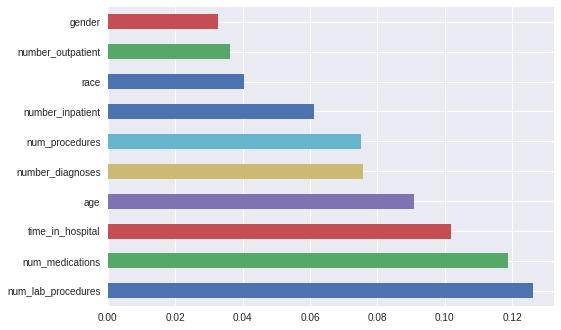

In [0]:
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier(n_estimators=100)
model.fit(df_train,y_train)

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=df_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Some of the algorithms work slightly better with scaled features

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(df_train)

df_train_scaled = scaler.transform(df_train)
df_val_scaled = scaler.transform(df_val)
df_test_scaled = scaler.transform(df_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  import sys


## Best Features and Algorithm Selection without Text Data

In this section, text features are not included in the training process . The Support Vector Machines with Radial Basis Kernel, the Gradient Boosting and Random Forest algorithms seems to have better results against others classifiers. Also, the Random Forest Classifer is being used for a feature selection procedure.

The parameters shown here are the result of an exhausing grid search procedure.

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.svm import SVC

svc = SVC(C=10, kernel='rbf', gamma='scale', probability=True, class_weight='balanced').fit(df_train, y_train)
xgb_model = xgb.XGBClassifier(objective="binary:logistic", booster="gbtree", eta="0.03", max_depth=5, colsample_bytree=0.65, random_state=42).fit(df_train, y_train)

estimator = RandomForestClassifier(n_estimators=200, max_depth=2, class_weight='balanced')
selector = RFE(estimator, 25, step=1, verbose=0)
selector = selector.fit(df_train, y_train)

rf = RandomForestClassifier(n_estimators=200, max_depth=2, class_weight='balanced').fit(df_train_scaled[:, selector.support_], y_train)

In [0]:
predictions_svm = svc.predict(df_val)
predictions_proba_svm = svc.predict_proba(df_val)[:, 1]

predictions_rf = rf.predict(df_val_scaled[:, selector.support_])
predictions_proba_rf = rf.predict_proba(df_val_scaled[:, selector.support_])[:, 1]

predictions_xgb = xgb_model.predict(df_val)
predictions_proba_xgb = xgb_model.predict_proba(df_val)[:, 1]

In [0]:
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix

print('SVM')
print_scores(y_val, svc.predict(df_val), svc.predict_proba(df_val)[:, 1])
print('RAN')
print_scores(y_val, rf.predict(df_val_scaled[:, selector.support_]), rf.predict_proba(df_val_scaled[:, selector.support_])[:, 1])
print('XGB')
print_scores(y_val, xgb_model.predict(df_val), xgb_model.predict_proba(df_val)[:, 1])

SVM
AUC:	 0.6433164673076662
F1:	 0.5519591141396933
RAN
AUC:	 0.6495991750517943
F1:	 0.5026666666666666
XGB
AUC:	 0.6527507154043616
F1:	 0.4733382030679328


(0.6527507154043616, 0.4733382030679328)

#### More results

We should mention that we also exeprimented with different classifiers, some of which managed to attain descent scores regarding ROC_AUC score, but failed in respect to the f1-score metric.

In [0]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV

C_params = [10**x for x in np.arange(-2.5,2.5,0.1)]
param_grid = {
        'penalty':['l1'], #lasso only
        'C':C_params
}

clf = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='roc_auc', verbose=3, n_jobs=10)
clf.fit(df_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    9.2s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:  1.6min
[Parallel(n_jobs=10)]: Done 250 out of 250 | elapsed:  9.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=10,
       param_grid={'penalty': ['l1'], 'C': [0.0031622776601683794, 0.003981071705534973, 0.005011872336272725, 0.006309573444801936, 0.00794328234724282, 0.01000000000000001, 0.012589254117941687, 0.01584893192461116, 0.01995262314968883, 0.025118864315095846, 0.03162277660168386, 0.03981071705534982, 0.05... 100.00000000000082, 125.8925411794179, 158.48931924611304, 199.52623149688992, 251.18864315096027]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=3)

In [0]:
print('LogisticRegression')
print_scores(y_val, clf.predict(df_val), clf.predict_proba(df_val)[:, 1])

LogisticRegression
AUC prob:	 0.6486792575048242
AUC:		 0.5716203608417063
F1:		 0.3547237076648842


(0.6486792575048242, 0.5716203608417063, 0.3547237076648842)

## Process text data. Effect on the prediction.

This section examines the text data influence on the model prediction. We should mention that the features used for this section correspond to both the diagnosis descriptions by the doctors, are well as the diagnosis themselves. Classic methods such as Bag of Words (BoF) and TF-IDF  are used to represent the text data. After a Non-Negative Matrix Factorization (NMF) is implemented as a latent representation of diagnosis text data. These latent factors stand for the text features. Furthermore, we experimented using an LSTM. We can expect the above methods to not work that well in our case, as we have a very limited size of data to handle. Many diseases and diagnosis are not adequately represented in the dataset. Finally, LSTM captures temporal relationships between successive words. As all the text data were aggregated, these relationships have been violated. We decided to test its performance however, as word embeddings, used by LSTM, may provide some useful results.

### stemming and vocab2number mapping

In [0]:
import nltk
nltk.download('wordnet')
nltk.download('rslp')
nltk.download('wordnet')
nltk.download('rslp')
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
import string

from collections import Counter

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

def thorough_filter(words):
    filtered_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in string.punctuation)
        if not all(pun):
            filtered_words.append(word)
    return filtered_words

def preprocess_document(document):
    words = nltk.word_tokenize(document.lower())
    filtered_words = [word for word in words if word not in stopwords.words('english') + list(string.punctuation)]
    filtered_words = thorough_filter(filtered_words)
    stemmed_words = [porter_stemmer.stem(wordnet_lemmatizer.lemmatize(word)) for word in filtered_words]
    cnt = Counter(stemmed_words)
    return cnt
  
preprocessed_features = [preprocess_document(text) for text in text_train]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
total_counter = preprocessed_features[0]
for i in range(1, len(preprocessed_features)):
    total_counter += preprocessed_features[i]

vocabulary = [word for word in total_counter]

In [0]:
vocabulary_mappings = {}
number = 0

for word in vocabulary:
    vocabulary_mappings[word] = number
    number += 1

### Bag of Words (BoW)

In [0]:
freq_array = np.zeros((len(preprocessed_features), len(vocabulary)))

for i in range(len(preprocessed_features)):
    for j in range(len(vocabulary)):
        freq_array[i,j] += preprocessed_features[i][vocabulary[j]] 

In [0]:
import numpy as np
from sklearn.decomposition import NMF

model = NMF(n_components=2, init='random', random_state=0)

# W size (number_of_documents, n_components)
# H size (n_components, number_of_words)

W = model.fit_transform(freq_array)
H = model.components_

In [0]:
from sklearn.model_selection import train_test_split

X_1, X_2, y_1, y_2 = train_test_split(W, y_train, test_size=0.33, random_state=42)

In [0]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(class_weight='balanced')
clf.fit(X_1, y_1)
preds = clf.predict(X_2)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
print(len(np.where(preds == 0)[0]))
print(len(np.where(preds == 1)[0]))

1295
685


In [0]:
from sklearn.metrics import roc_auc_score, f1_score

print(roc_auc_score(y_2, preds))
print(f1_score(y_2, preds))

0.4956679133925813
0.36101578586135896


The results in this case are not promising at all (close to random).

### TF-IDF

In [0]:
for i in range(len(freq_array)):
    freq_array[i, :] = freq_array[i, :] / freq_array.sum(axis=1)[i]

In [0]:
non_zero_elements_per_row = np.zeros((len(freq_array[0])))

for i in range(len(freq_array)):
    for j in range(len(freq_array[0])):
        if freq_array[i,j]>0.0:
            non_zero_elements_per_row[j] += 1

idf = np.log10(float(len(freq_array))/non_zero_elements_per_row)

In [0]:
tf_idf = freq_array * idf

In [0]:
import numpy as np
from sklearn.decomposition import NMF

model = NMF(n_components=20, init='random', random_state=0)

# W size (number_of_documents, n_components)
# H size (n_components, number_of_words)

W = model.fit_transform(freq_array)
H = model.components_

In [0]:
from sklearn.model_selection import train_test_split

X_1, X_2, y_1, y_2 = train_test_split(W, y_train, test_size=0.33, random_state=42)

In [0]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(class_weight='balanced')
clf.fit(X_1, y_1)
preds = clf.predict(X_2)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
from sklearn.metrics import roc_auc_score, f1_score

print(roc_auc_score(y_2, preds))
print(f1_score(y_2, preds))

0.5140256665408504
0.36481614996395095


Again, this method does not provide usedful results.

### LSTM

In [0]:
def tokenize_features(document):
    words = nltk.word_tokenize(document.lower())
    filtered_words = [word for word in words if word not in stopwords.words('english') + list(string.punctuation)]
    filtered_words = thorough_filter(filtered_words)
    stemmed_words = [porter_stemmer.stem(wordnet_lemmatizer.lemmatize(word)) for word in filtered_words]
    return stemmed_words
  
new_features = [[vocabulary_mappings[word] for word in tokenize_features(feature)] for feature in text_train]
new_features = np.array(new_features)

In [0]:
# preproccess validation and test the same way

def process_same_text(features_text, vocabulary_mappings):
    new_features = []
    for feature in features_text:
        new_feature = []
        tokenized_feature = tokenize_features(feature)
        for token in tokenized_feature:
            if token in vocabulary_mappings:
                new_feature.append(vocabulary_mappings[token])
        new_features.append(new_feature)
    return np.array(new_features)

features_valid_n = process_same_text(text_valid, vocabulary_mappings)
features_test_n = process_same_text(text_test, vocabulary_mappings)

In [0]:
from keras.preprocessing import sequence 

max_review_length = max(max(len(l) for l in new_features), max(len(l) for l in features_valid_n))
new_features_padded = sequence.pad_sequences(new_features, maxlen=max_review_length) 
features_valid_padded = sequence.pad_sequences(features_valid_n, maxlen=max_review_length) 
features_test_padded = sequence.pad_sequences(features_test_n, maxlen=max_review_length) 

Using TensorFlow backend.


In [0]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, LSTM
from keras.layers import Bidirectional
import keras 

embedding_vector_length = 25

model = Sequential()
model.add(Embedding(len(vocabulary), embedding_vector_length, input_length=max_review_length))
model.add(Bidirectional(LSTM(10)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 38, 25)            37075     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 20)                2880      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 21        
Total params: 39,976
Trainable params: 39,976
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
from keras.callbacks import ModelCheckpoint

filepath="weights-{epoch:02d}-{val_f1:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_f1', verbose=1, save_best_only=False)
callbacks_list = [checkpoint]

model.fit(new_features_padded, y_train, validation_data=(features_valid_padded, y_val), epochs=5, batch_size=64, callbacks=callbacks_list)

Train on 6000 samples, validate on 2000 samples
Epoch 1/5
6000/6000 [==============================] - 7s 1ms/step - loss: 0.6735 - f1: 0.0046 - val_loss: 0.6679 - val_f1: 0.0000e+00

Epoch 00001: saving model to weights-01-0.000.hdf5
Epoch 2/5
6000/6000 [==============================] - 4s 642us/step - loss: 0.6615 - f1: 0.0520 - val_loss: 0.6586 - val_f1: 0.1085

Epoch 00002: saving model to weights-02-0.109.hdf5
Epoch 3/5
6000/6000 [==============================] - 4s 648us/step - loss: 0.6519 - f1: 0.2199 - val_loss: 0.6564 - val_f1: 0.2985

Epoch 00003: saving model to weights-03-0.299.hdf5
Epoch 4/5
6000/6000 [==============================] - 4s 641us/step - loss: 0.6409 - f1: 0.3770 - val_loss: 0.6610 - val_f1: 0.3611

Epoch 00004: saving model to weights-04-0.361.hdf5
Epoch 5/5
6000/6000 [==============================] - 4s 647us/step - loss: 0.6329 - f1: 0.3726 - val_loss: 0.6685 - val_f1: 0.3305

Epoch 00005: saving model to weights-05-0.331.hdf5


In [0]:
!ls

sample_data	       weights-02-0.231.hdf5  weights-04-0.322.hdf5
weights-01-0.000.hdf5  weights-03-0.269.hdf5  weights-05-0.385.hdf5


In [0]:
model.load_weights('weights-05-0.331.hdf5')

In [0]:
preds = model.predict(features_valid_padded).reshape(-1)

In [0]:
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix

threshold = 0.2

print(roc_auc_score(y_val, preds))
print(roc_auc_score(y_val, (preds > threshold).astype(np.int)))
print()
print(confusion_matrix(y_val, (preds > threshold).astype(np.int)))
print(classification_report(y_val, (preds > threshold).astype(np.int)))

0.5951135191834935
0.5323021132506783

[[ 183 1024]
 [  69  724]]
              precision    recall  f1-score   support

           0       0.73      0.15      0.25      1207
           1       0.41      0.91      0.57       793

   micro avg       0.45      0.45      0.45      2000
   macro avg       0.57      0.53      0.41      2000
weighted avg       0.60      0.45      0.38      2000



## Combine result

Having find different fairly good models, we attempt to properly combine them looking for an even better result. Also, because of the relatively low F1 score, an optimal desicion threshold for the acceptance of the positive class,with respect to the probability to be positive, is needed.Finally a Grid search over the importance of each classifier and different values of the threshold is performed.

In [0]:
# preds, prediction_pro, prediction_pro_rf

predictions = np.array([predictions_proba_svm, predictions_proba_rf, predictions_proba_xgb, preds]).T

In [0]:
%%capture

best_roc = -1
best_f1 = -1

for w1 in np.arange(0.1, 1, 0.1):
    for w2 in np.arange(0, 1, 0.1):
        for w3 in np.arange(0, 1, 0.1):
            for w4 in np.arange(0, 1, 0.1):
                weights = [w1, w2, w3, w4]
                for threshold in np.arange(0, 1, 0.05):
                    preds_new = np.sum((predictions * weights) , axis=1) / np.sum(weights)

                    roc, f1 = print_scores(y_val, (preds_new > threshold).astype(np.int), preds_new, verbose=False)

                    if roc > best_roc:
                        best_roc = roc
                        best_scores_roc = (roc, f1, weights, threshold)

                    if f1 > best_f1:
                        best_f1 = f1
                        best_scores_f1 = (roc, f1, weights, threshold)

In [0]:
print(best_scores_roc)
print(best_scores_f1)

We set the best weights that we found for the f1-score. That is because, best weights for ROC_AUC curve tend to have bad results what the f1 score is concerned.

In [0]:
weights = [0.4, 0.9, 0.3, 0.5] 
threshold = 0.4

preds_new = np.sum((predictions * weights) , axis=1) / np.sum(weights)

roc, f1 = print_scores(y_val, (preds_new > threshold).astype(np.int), preds_new, verbose=False)

print(roc, f1)

Based on the best results attained above, we examine the performance on the test set.

In [0]:
predictions_svm_test = svc.predict(df_test)
predictions_proba_svm_test = svc.predict_proba(df_test)[:, 1]

predictions_rf_test = rf.predict(df_test_scaled[:, selector.support_])
predictions_proba_rf_test = rf.predict_proba(df_test_scaled[:, selector.support_])[:, 1]

predictions_xgb_test = xgb_model.predict(df_test)
predictions_proba_xgb_test = xgb_model.predict_proba(df_test)[:, 1]

preds_test = model.predict(features_test_padded).reshape(-1)

predictions_test = np.array([predictions_proba_svm_test, predictions_proba_rf_test, predictions_proba_xgb_test, preds_test]).T

In [0]:
preds_new_test = np.sum((predictions_test * weights) , axis=1) / np.sum(weights)

print_scores(y_test, (preds_new_test > threshold).astype(np.int), preds_new_test)

The final results we got for the validation and test set are:

* Validation set: 
 - roc_score: 0.6690584 
 - f1_score:   0.5994424
* Test set: 
 - roc_score: 0.6645597
 - f1_score:   0.5983146

Finally, we plot the roc curves for the validation and the test set.

In [0]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def plot_roc_curve(true_values, predicted_values):
    # compute ROC curve
    fpr, tpr, thresholds_roc = roc_curve(true_values, predicted_values)
    roc_auc = auc(fpr, tpr)
    precision, recall, thresholds_prc = precision_recall_curve(true_values, predicted_values)

    # compute precision-recall curve
    auprc = auc(recall, precision)
    precision_random, recall_random, thresholds_random = precision_recall_curve(true_values, np.random.rand(len(true_values)))
    auprc_random = auc(recall_random, precision_random)
    other_scores_validation = [roc_auc, auprc, auprc_random]

    # plot curves
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
                     lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('1 - Specificity / False Positive Rate')
    plt.ylabel('Sensibility / True Positive Rate')
    plt.legend(loc="lower right")

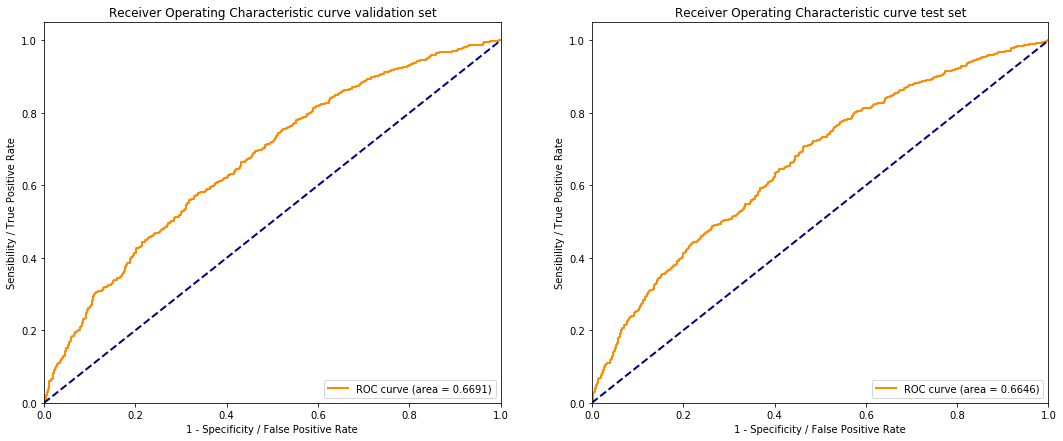

In [0]:
from pylab import rcParams

%matplotlib inline

rcParams['figure.figsize'] = 18, 7

plt.figure()

plt.subplot(1, 2, 1)
plot_roc_curve(y_val, preds_new)
plt.title('Receiver Operating Characteristic curve validation set')

plt.subplot(1, 2, 2)
plot_roc_curve(y_test, preds_new_test)
plt.title('Receiver Operating Characteristic curve test set')

plt.show()